In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

# Import your custom solver module.
# Replace the following import with the actual location of Solve_IVP_NS.
# For example, if your module is in the same directory, you might do:
# from Solve_IVP_NS import solve_ivp_ns
import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH


In [36]:
# -----------------------------
# Problem setup (state y = [v, s])
# -----------------------------
m, g = 1.0, 9.81
e = 0.8
q0, v0 = 2.0, 1.0          # initial height and velocity
h0 = 1e-3                  # initial step guess (adaptive will change it)
T_final = 10.0
t_span = (0.0, T_final)
component_slices = [slice(0,1), slice(1,2)]  # [v], [s]
A = None  # mass/descriptor matrix; None=Identity (fine here)

In [37]:

def rhs(t, y):
    """Unconstrained smooth dynamics: y = [v, s] -> [dv/dt, ds/dt]"""
    v = y[0]
    v_dot = -g
    s_dot = v
    return np.array([v_dot, s_dot], dtype=float)

def rhs_jacobian(t, y, Fk=None):
    """Analytical Jacobian df/dy for rhs(t,y) with y=[v,s]."""
    # dv_dot/dv = 0, dv_dot/ds = 0
    # ds_dot/dv = 1, ds_dot/ds = 0
    J = np.zeros((2, 2), dtype=float)
    J[1, 0] = 1.0
    return J


In [45]:
# General Moreau VI callbacks (one contact channel)
def gap_ball(t, y):
    """Gap: s >= 0 is feasible."""
    return np.array([y[1]], dtype=float)

def u_ball(t, y):
    """Normal channel 'velocity': here just the vertical velocity v."""
    return np.array([y[0]], dtype=float)

def Ju_ball(t, y):
    """du/dy for u=v with y=[v,s]."""
    J = np.zeros((1, 2), dtype=float)
    J[0, 0] = 1.0
    return J

def G_ball_factory(mass):
    """Map normal impulse λ to state increment Δy; λ only affects velocity."""
    def G_ball(t, y, lam_full):
        lam = float(lam_full[0])
        dv = lam / mass
        return np.array([dv, 0.0], dtype=float)
    return G_ball


    
# Build projection via the general Moreau VI projector
projection_opts = dict(
    gap=gap_ball,
    u_map=u_ball,
    J_u=Ju_ball,
    G_apply=G_ball_factory(m),
    e=e,
    gap_tol=1e-10*0,
    lcp_maxit=200,
    lcp_tol=1e-10,
    tc_tol=1e-10,
 )

In [51]:
# Common nonlinear-solver options
solver_opts_common = dict(
    tol=1e-7,
    max_iter=200,
    rhs_jac=rhs_jacobian,      # enables exact residual Jacobian in integrators
    # sparse='auto',
    # sparse_threshold=400,      # bump if you like
    linear_solver='splu',      # direct sparse LU for robustness
    # gmres_tol=1e-4,
    globalization='linesearch',      # Armijo backtracking for difficult kinks
    max_backtracks=25,
    ls_min_alpha=1e-10,
    # vi_strict_block_lipschitz=False

)

# Adaptive controller options passed via high-level API
adaptive_opts = dict(
    h0=h0,
    h_min=1e-12,
    h_down=0.5, h_up=1.5,
    # safety=0.85,
    method_order=1,           # conservative order for nonsmooth dynamics
    use_PI=False,              # smoother steps
    skip_error_indices=[]    # don't penalize [v] block in LTE
 )

# SSN-specific tweaks for robustness
solver_opts_ssn = dict(solver_opts_common)
solver_opts_ssn.update(dict(
    linear_tol_strategy='eisenstat',   # dynamic inner tol (enables EW)
    lam=0.2,                           # smaller Newton damping helps at impacts
    # use_broyden=True,                  # dense quasi-Newton fallback if dense path
    # sparse=False,                    # uncomment to force dense if tiny systems
))

In [ ]:
# -----------------------------
# Solve with VI
# -----------------------------
tic_vi = time.time()
t_vi, y_vi, h_vi, fk_vi, info_vi = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=np.array([v0, q0], dtype=float),
    method='trapezoidal',                  # TR-BE (second order style)
    projection='unilateral',               # use the general projector
    solver='VI',
    projection_opts=projection_opts,
    solver_opts=solver_opts_common,
    adaptive=True,
    adaptive_opts=adaptive_opts,
    atol=1e-6,
    rtol=1e-3,
    h0=h0,
    component_slices=component_slices,
    verbose=False,
    A=A
)
toc_vi = time.time() - tic_vi
print(f"VI solve OK in {toc_vi:.3f}s, steps={len(t_vi)-1}, last h={h_vi[-1]:.3e}, last time t={t_vi[-1]}")

unilateral


In [ ]:

 # -----------------------------
# Solve with semismooth Newton
# -----------------------------
tic_sn = time.time()
t_sn, y_sn, h_sn, fk_sn, info_sn = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=np.array([v0, q0], dtype=float),
    method='trapezoidal',   # BE is more forgiving at nonsmooth events
    projection='unilateral',
    solver='semismooth_newton',
    projection_opts=projection_opts,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    adaptive_opts=adaptive_opts,         # tuned above

    atol=1e-6,
    rtol=1e-3,
    h0=h0,
    component_slices=component_slices,
    verbose=True,
    
    A=A
)
toc_sn = time.time() - tic_sn
print(f"SSN solve OK in {toc_sn:.3f}s, steps={len(t_sn)-1}, last h={h_sn[-1]:.3e}")


unilateral
 convergent reject @ t=0.581859,h -> 1.460e-01
 convergent reject @ t=0.581859,h -> 7.298e-02
 convergent reject @ t=0.581859,h -> 3.649e-02
 convergent reject @ t=0.61835,h -> 2.737e-02
 convergent reject @ t=0.61835,h -> 1.368e-02
 convergent reject @ t=0.632034,h -> 1.026e-02
 convergent reject @ t=0.632034,h -> 5.132e-03
 convergent reject @ t=0.637165,h -> 3.849e-03
 convergent reject @ t=0.637165,h -> 1.924e-03
 convergent reject @ t=0.637165,h -> 9.622e-04
 convergent reject @ t=0.638128,h -> 7.216e-04
 convergent reject @ t=0.638128,h -> 3.608e-04
 convergent reject @ t=0.638488,h -> 2.706e-04
 convergent reject @ t=0.638488,h -> 1.353e-04
 convergent reject @ t=0.638488,h -> 6.765e-05
 convergent reject @ t=0.638488,h -> 3.383e-05
 convergent reject @ t=0.638522,h -> 2.537e-05
 convergent reject @ t=0.638548,h -> 1.903e-05
 convergent reject @ t=0.638548,h -> 9.514e-06
 convergent reject @ t=0.638548,h -> 4.757e-06
 convergent reject @ t=0.638548,h -> 2.378e-06
 con

In [ ]:

# -----------------------------
# Event-driven reference (for validation)
# -----------------------------
def step_free(q, v, dt, g=g):
    v_new = v - g * dt
    q_new = q + dt * v - 0.5 * g * dt * dt
    return q_new, v_new

def simulate_event_driven(m=1.0, g=9.81, e=0.85, q0=2.0, v0=0.0, h=5e-4, T=3.0):
    n = int(np.ceil(T / h))
    t = np.linspace(0.0, n*h, n+1)
    q = np.zeros(n+1); v = np.zeros(n+1)
    q[0], v[0] = q0, v0
    for k in range(n):
        q_free, v_free = step_free(q[k], v[k], h, g=g)
        if q_free >= 0.0:
            q[k+1], v[k+1] = q_free, v_free
            continue
        # find exact impact time τ in (0,h]
        a = -0.5*g; b = v[k]; c = q[k]
        disc = b*b - 4*a*c
        tau = h
        if disc >= 0.0 and a != 0.0:
            rtd = np.sqrt(disc)
            t1 = (-b + rtd)/(2*a)
            t2 = (-b - rtd)/(2*a)
            cands = [tt for tt in (t1, t2) if 0.0 < tt <= h]
            if cands: tau = min(cands)
        q_imp, v_minus = step_free(q[k], v[k], tau, g=g)
        v_plus = -e * v_minus
        q_imp = 0.0
        rem = h - tau
        q_end, v_end = step_free(q_imp, v_plus, rem, g=g)
        q[k+1], v[k+1] = q_end, v_end
    return t, q, v

t_ev, q_ev, v_ev = simulate_event_driven(m=m, g=g, e=e, q0=q0, v0=v0, h=h0, T=T_final)


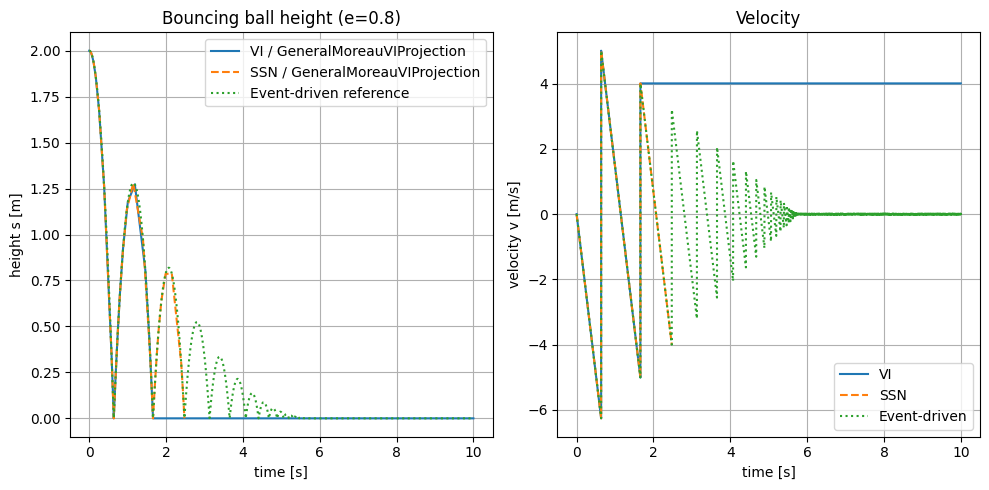

VI apex heights (first 5): [1.273265]
VI apex ratios (~e^2):     []  target: 0.6400000000000001
EV apex heights (first 5): [1.279999 0.8192   0.524287 0.335544 0.214748]
EV apex ratios (~e^2):     [0.64     0.639999 0.640001 0.639999]  target: 0.6400000000000001


In [ ]:

# -----------------------------
# Plot results
# -----------------------------
v_vi, s_vi = y_vi[:, 0], y_vi[:, 1]
v_sn, s_sn = y_sn[:, 0], y_sn[:, 1]

plt.figure(figsize=(10, 5))

# Height
plt.subplot(1, 2, 1)
plt.plot(t_vi, s_vi, label='VI / GeneralMoreauVIProjection')
plt.plot(t_sn, s_sn, '--', label='SSN / GeneralMoreauVIProjection')
plt.plot(t_ev, q_ev, ':', label='Event-driven reference')
plt.xlabel('time [s]'); plt.ylabel('height s [m]')
plt.title(f'Bouncing ball height (e={e})')
plt.legend(); plt.grid(True)

# Velocity
plt.subplot(1, 2, 2)
plt.plot(t_vi, v_vi, label='VI')
plt.plot(t_sn, v_sn, '--', label='SSN')
plt.plot(t_ev, v_ev, ':', label='Event-driven')
plt.xlabel('time [s]'); plt.ylabel('velocity v [m/s]')
plt.title('Velocity')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------
# Apex ratio quick check (~ e^2)
# -----------------------------
def apexes(q, t):
    peaks = []
    tpeaks = []
    for i in range(1, len(q)-1):
        if q[i] > q[i-1] and q[i] > q[i+1]:
            peaks.append(q[i]); tpeaks.append(t[i])
    return np.array(tpeaks), np.array(peaks)

_, peaks_vi = apexes(s_vi, t_vi)
_, peaks_ev = apexes(q_ev, t_ev)

def ratios(peaks):
    return [peaks[i+1]/peaks[i] for i in range(len(peaks)-1)]

print("VI apex heights (first 5):", np.round(peaks_vi[:5], 6))
print("VI apex ratios (~e^2):    ", np.round(ratios(peaks_vi)[:4], 6), " target:", e*e)
print("EV apex heights (first 5):", np.round(peaks_ev[:5], 6))
print("EV apex ratios (~e^2):    ", np.round(ratios(peaks_ev)[:4], 6), " target:", e*e)

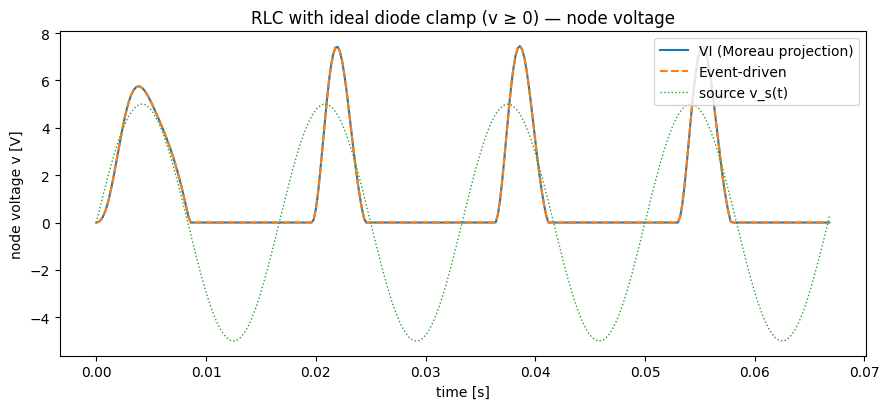

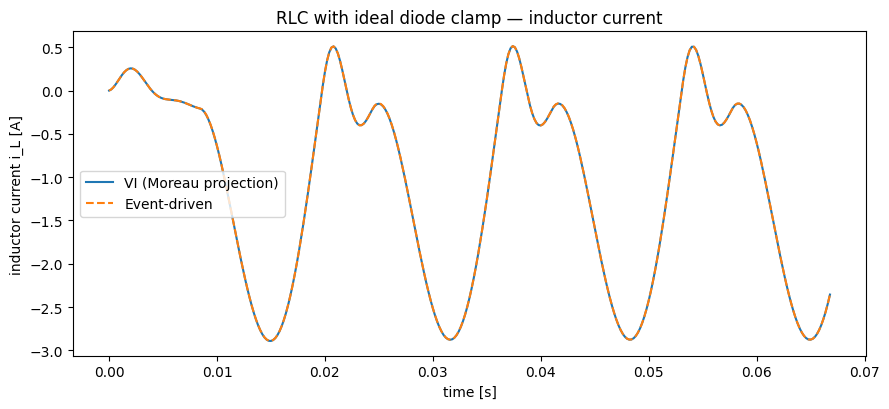

Estimated diode conduction duty  (VI): 0.660
Estimated diode conduction duty (EV): 0.660


In [44]:
# Fix naming collision: rename resistance parameter to Rs in the residual builder.

import numpy as np
import math
import matplotlib.pyplot as plt

class GeneralMoreauVIProjection:
    def __init__(self, gap, u_map, J_u, G_apply, e=0.0, gap_tol=0.0, lcp_maxit=80, lcp_tol=1e-12):
        self.gap = gap; self.u_map = u_map; self.J_u = J_u; self.G_apply = G_apply
        self.e = e; self.gap_tol = float(gap_tol); self.lcp_maxit = int(lcp_maxit); self.lcp_tol = float(lcp_tol)
    @staticmethod
    def _solve_Rplus_LCP_pg(W, b, maxit, tol):
        r = np.zeros_like(b); alpha = 1.0/np.clip(np.diag(W), 1e-16, np.inf)
        for _ in range(maxit):
            z = W @ r + b
            r_new = np.maximum(0.0, r - alpha*z)
            if np.linalg.norm(r_new - r) < tol: r=r_new; break
            r = r_new
        return r
    def project(self, state, state_minus_rhoR, rho, t=None, Fk_val=None, prev_state=None):
        y_it = np.asarray(state,float); y_bar = np.asarray(state_minus_rhoR,float).copy()
        g_bar = np.asarray(self.gap(t,y_bar),float); g_it = np.asarray(self.gap(t,y_it),float)
        active = np.where(np.minimum(g_bar,g_it) <= self.gap_tol)[0]
        if active.size==0: return y_bar
        J = np.asarray(self.J_u(t,y_bar),float); m = J.shape[0]; m_a = active.size
        def restrict(v): return np.asarray(v,float)[active]
        def embed(v_a): w=np.zeros(m); w[active]=np.asarray(v_a,float); return w
        u_free_full = np.asarray(self.u_map(t,y_bar),float); u_free = restrict(u_free_full)
        if prev_state is not None and np.any(self.e):
            e = np.asarray(self.e,float); 
            if e.size==1: e=np.full(m,float(e))
            u_prev = restrict(self.u_map(t,prev_state)); b = u_free + e[active]*u_prev
        else: b = u_free.copy()
        W = np.zeros((m_a,m_a))
        for j in range(m_a):
            ej_full = embed(np.eye(m_a)[:,j])
            dy = self.G_apply(t,y_bar,ej_full)
            du_full = J @ dy
            W[:,j] = restrict(du_full)
        lam_a = self._solve_Rplus_LCP_pg(W,b,self.lcp_maxit,self.lcp_tol)
        lam_full = embed(lam_a); dy = self.G_apply(t,y_bar,lam_full)
        return y_bar + dy

class VI_Solver:
    def __init__(self, proj, rho0=1.0, tol=1e-12, max_iter=80):
        self.proj=proj; self.rho0=float(rho0); self.tol=float(tol); self.max_iter=int(max_iter); self.prev_state=None
    def solve(self, func_R, y0, t=None):
        yk=y0.copy(); rho=self.rho0
        Fk=func_R(yk)
        y_proj=self.proj.project(yk, yk-rho*Fk, rho, t=t, Fk_val=Fk, prev_state=self.prev_state)
        err=np.linalg.norm(yk-y_proj); k=0
        while err>self.tol and k<self.max_iter:
            Fk=func_R(yk)
            yk1=self.proj.project(yk, yk-rho*Fk, rho, t=t, Fk_val=Fk, prev_state=self.prev_state)
            Fk1=func_R(yk1)
            err=np.linalg.norm(yk1 - self.proj.project(yk1, yk1 - rho*Fk1, rho, t=t, Fk_val=Fk1, prev_state=self.prev_state))
            yk=yk1; k+=1
        return yk

def make_BE_residual_RLC(y_prev, h, Rs, L, C, vs_func, t_next):
    v_prev, i_prev = float(y_prev[0]), float(y_prev[1])
    def Rres(y):
        v, i = float(y[0]), float(y[1])
        dv = i / C
        di = (vs_func(t_next) - Rs * i - v) / L
        return np.array([ v - v_prev - h*dv, i - i_prev - h*di ])
    return Rres

def gap_diode(t,y): return np.array([y[0]])
def u_diode(t,y):   return np.array([y[0]])
def Ju_diode(t,y):  return np.array([[1.0, 0.0]])
def G_from_diode_current_factory(C):
    def G_apply(t,y,lam_full):
        dv=float(lam_full[0])/C
        return np.array([dv, 0.0])
    return G_apply

def simulate_RLC_VI(T=0.06, h=2e-5, Rs=1.0, L=5e-3, C=100e-6, V0=5.0, freq=60.0, v0=0.0, i0=0.0):
    omega=2*np.pi*freq; vs=lambda t: V0*np.sin(omega*t)
    proj=GeneralMoreauVIProjection(gap=gap_diode, u_map=u_diode, J_u=Ju_diode, G_apply=G_from_diode_current_factory(C),
                                   e=0.0, gap_tol=0.0, lcp_maxit=60, lcp_tol=1e-12)
    solver=VI_Solver(proj, rho0=1.0, tol=1e-12, max_iter=60)
    N=int(math.ceil(T/h)); t=np.linspace(0.0, N*h, N+1); Y=np.zeros((N+1,2)); Y[0]=[v0,i0]
    for k in range(N):
        R_be=make_BE_residual_RLC(Y[k], h, Rs, L, C, vs, t[k+1])
        solver.prev_state=Y[k].copy()
        v_pred=Y[k,0] + h*(Y[k,1]/C)
        i_pred=Y[k,1] + h*((vs(t[k]) - Rs*Y[k,1] - Y[k,0])/L)
        y0=np.array([v_pred, i_pred])
        Y[k+1]=solver.solve(R_be, y0, t=t[k+1])
        if Y[k+1,0]<0 and abs(Y[k+1,0])<1e-12: Y[k+1,0]=0.0
    return t, Y, vs

def simulate_RLC_event(T=0.06, h=2e-5, Rs=1.0, L=5e-3, C=100e-6, V0=5.0, freq=60.0, v0=0.0, i0=0.0):
    omega=2*np.pi*freq; vs=lambda t: V0*np.sin(omega*t)
    def BE_free_step(v,i,t,h):
        A=np.array([[1.0, -h/C],
                    [h/L, 1.0 + h*Rs/L]])
        b=np.array([v, i + h*vs(t+h)/L])
        x=np.linalg.solve(A,b)
        return x[0], x[1]
    def BE_clamped_step(i,t,h):
        return (i + (h/L)*vs(t+h)) / (1.0 + h*Rs/L)
    N=int(math.ceil(T/h)); t=np.linspace(0.0, N*h, N+1); v=np.zeros(N+1); i=np.zeros(N+1); v[0]=v0; i[0]=i0
    for k in range(N):
        v_free, i_free = BE_free_step(v[k], i[k], t[k], h)
        if v_free >= 0.0:
            v[k+1], i[k+1] = v_free, i_free
            continue
        tau = h * v[k] / (v[k] - v_free) if v[k] != v_free else 0.0
        tau = np.clip(tau, 0.0, h)
        v_imp, i_imp = BE_free_step(v[k], i[k], t[k], tau)
        v_imp = 0.0
        i_end = BE_clamped_step(i_imp, t[k] + tau, h - tau)
        v[k+1], i[k+1] = 0.0, i_end
    Y=np.vstack([v,i]).T
    return t, Y, vs

# Run and plot
Rs, L, C = 1.0, 5e-3, 100e-6
V0, freq = 5.0, 60.0
T = 4.0/freq
h = 2e-4
v0, i0 = 0.0, 0.0

t_vi, Y_vi, vs = simulate_RLC_VI(T=T, h=h, Rs=Rs, L=L, C=C, V0=V0, freq=freq, v0=v0, i0=i0)
t_ev, Y_ev, vs2 = simulate_RLC_event(T=T, h=h, Rs=Rs, L=L, C=C, V0=V0, freq=freq, v0=v0, i0=i0)

plt.figure(figsize=(9,4.2))
plt.plot(t_vi, Y_vi[:,0], label="VI (Moreau projection)")
plt.plot(t_ev, Y_ev[:,0], "--", label="Event-driven")
plt.plot(t_vi, V0*np.sin(2*np.pi*freq*t_vi), ":", label="source v_s(t)", linewidth=1.0)
plt.xlabel("time [s]"); plt.ylabel("node voltage v [V]")
plt.title("RLC with ideal diode clamp (v ≥ 0) — node voltage")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4.2))
plt.plot(t_vi, Y_vi[:,1], label="VI (Moreau projection)")
plt.plot(t_ev, Y_ev[:,1], "--", label="Event-driven")
plt.xlabel("time [s]"); plt.ylabel("inductor current i_L [A]")
plt.title("RLC with ideal diode clamp — inductor current")
plt.legend(); plt.tight_layout(); plt.show()

duty_vi = np.mean(Y_vi[:,0] <= 1e-10)
duty_ev = np.mean(Y_ev[:,0] <= 1e-10)
print(f"Estimated diode conduction duty  (VI): {duty_vi:.3f}")
print(f"Estimated diode conduction duty (EV): {duty_ev:.3f}")
